NAME:

---

In [1]:
import yfinance as yf
sp500=yf.Ticker("^GSPC")#GSPC index de sp500
sp500=sp500.history(period="max")#pandas dataframe que les jours de trading 
sp500.index
print(sp500)

                                  Open         High          Low        Close  \
Date                                                                            
1927-12-30 00:00:00-05:00    17.660000    17.660000    17.660000    17.660000   
1928-01-03 00:00:00-05:00    17.760000    17.760000    17.760000    17.760000   
1928-01-04 00:00:00-05:00    17.719999    17.719999    17.719999    17.719999   
1928-01-05 00:00:00-05:00    17.549999    17.549999    17.549999    17.549999   
1928-01-06 00:00:00-05:00    17.660000    17.660000    17.660000    17.660000   
...                                ...          ...          ...          ...   
2024-05-13 00:00:00-04:00  5233.080078  5237.259766  5211.160156  5221.419922   
2024-05-14 00:00:00-04:00  5221.100098  5250.370117  5217.979980  5246.680176   
2024-05-15 00:00:00-04:00  5263.259766  5311.759766  5263.259766  5308.149902   
2024-05-16 00:00:00-04:00  5310.069824  5325.490234  5296.189941  5297.100098   
2024-05-17 00:00:00-04:00  5

                                  Open         High          Low        Close  \
Date                                                                            
1990-01-02 00:00:00-05:00   353.399994   359.690002   351.980011   359.690002   
1990-01-03 00:00:00-05:00   359.690002   360.589996   357.890015   358.760010   
1990-01-04 00:00:00-05:00   358.760010   358.760010   352.890015   355.670013   
1990-01-05 00:00:00-05:00   355.670013   355.670013   351.350006   352.200012   
1990-01-08 00:00:00-05:00   352.200012   354.239990   350.540009   353.790009   
...                                ...          ...          ...          ...   
2024-05-13 00:00:00-04:00  5233.080078  5237.259766  5211.160156  5221.419922   
2024-05-14 00:00:00-04:00  5221.100098  5250.370117  5217.979980  5246.680176   
2024-05-15 00:00:00-04:00  5263.259766  5311.759766  5263.259766  5308.149902   
2024-05-16 00:00:00-04:00  5310.069824  5325.490234  5296.189941  5297.100098   
2024-05-17 00:00:00-04:00  5

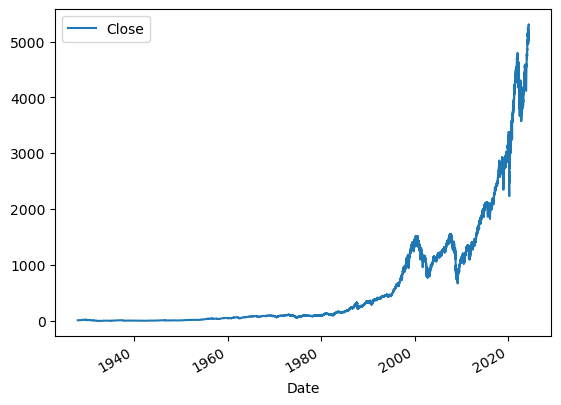

In [2]:
sp500.plot.line(y="Close",use_index=True)#tracer le prix de fermeture en fonction de l'année
del sp500["Dividends"] #effacer les colonnes dont on a pas besoin 
del sp500["Stock Splits"]

#pas interet de predire le prix de demain ,pas besoin de savoir le prix il faut une prediction pour soit le prix augmente ou baisse
sp500["hier"] = sp500["Close"].shift(1)  # Create a column for the closing price of the previous day

# Create the "Target" column based on the condition
sp500["Target"] = (sp500["hier"] < sp500["Close"]).astype(int)
sp500=sp500.loc["1990-01-01":].copy()#ne prendre que les prix ou la date est sup au moins à 1990
print(sp500)

[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1]
0.5454545454545454


<Axes: xlabel='Date'>

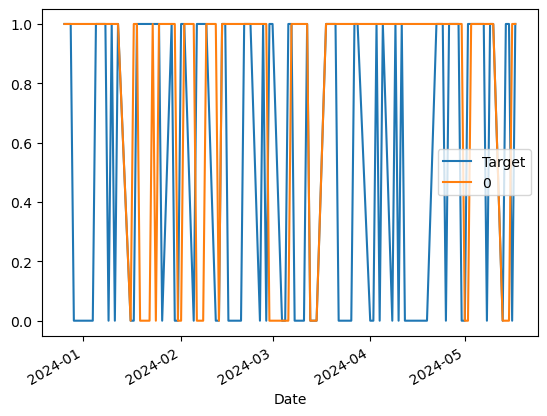

In [3]:
from sklearn.ensemble import RandomForestClassifier#peut détecter les non linearités entre les parametres
#random traine un groupe d'arbre de décision individuels avce des paramétres randoms puis faire la moyenne de ces resulats 
model=RandomForestClassifier(n_estimators=100,min_samples_split=100,random_state=1)
#n estimators le nombre de decisions individuels que nous voulons trainer si ce nombre augement la precision est plus elevé
#min samples split pour definir la repartition minimale de l'echantillon higher the less accurate
# random state signifie si on exécute le modéle deux fois les nombres généres seront dans une séquence prévisible si on tourne le code deux fois on aura les memes resulats
# separer nos donnes en deux données d'entrainement et données de test
 

train=sp500.iloc[:-100]
test=sp500.iloc[-100:]#les 100 dernieres lignes
predictors=["Close","Volume","Open","High","Low"]
model.fit(train[predictors],train["Target"])#entrainer les predictors pour préduire le target 
#mesurer les performances du modéle

from sklearn.metrics import precision_score
preds=model.predict(test[predictors])
print(preds)
import pandas as pd
preds=pd.Series(preds,index=test.index)
print(precision_score(test["Target"],preds))#le resultat
combined=pd.concat([test["Target"],preds],axis=1)
combined.plot()#0 orange prediction bleu réalité

In [4]:
#creer un algorithme plus robuste 
#back testing 
def predict(train,test,predictors,model):
    model.fit(train[predictors],train["Target"])
    preds=model.predict(test[predictors])
    preds=pd.Series(preds,index=test.index,name="Predictions")
    combined=pd.concat([test["Target"],preds],axis=1)
    return combined  

In [5]:
def backtest(data,model,predictors,start=2500,step=250):
    #Pour faire un backtest  on doit avoir un certain nombre de données pour l'entrainement donc chaque anneé on a 250 jours ce qui signifie qu'on doit prendre 10 ans de data on doit entrainer le modele pour une année puis passer à l'année suivante on prend les données de 10 nas pour pouvoir prédire le 11 ans 
    all_predictions=[]
    for i in range(start,data.shape[0],step):
        train=data.iloc[0:i].copy()
        test=data.iloc[i:(i+step)].copy()
        predictions=predict(train,test,predictors,model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions) 

In [6]:
predictions=backtest(sp500,model,predictors)

In [7]:
predictions["Predictions"].value_counts()

1    3545
0    2616
Name: Predictions, dtype: int64

In [8]:
print(precision_score(predictions["Target"],predictions["Predictions"]))

0.6406205923836389


<Axes: xlabel='Date'>

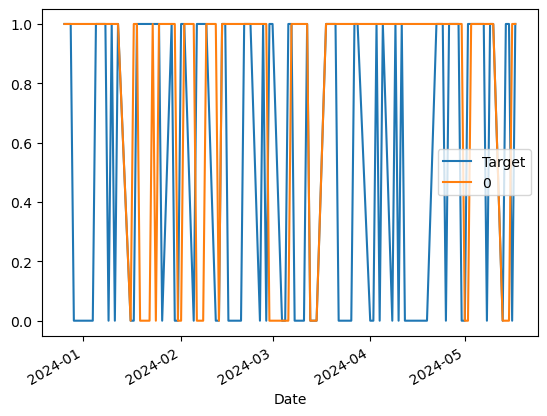

In [9]:
combined=pd.concat([test["Target"],preds],axis=1)
combined.plot()#0 orange prediction bleu réalité

0.5555555555555556


<Axes: xlabel='Date'>

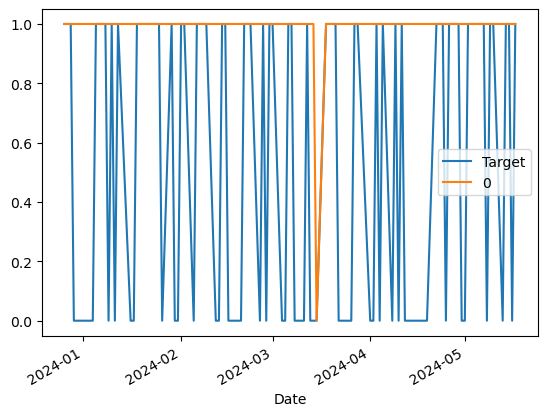

In [10]:
predictors=["Close","Volume","Low"]
model.fit(train[predictors],train["Target"])#entrainer les predictors pour préduire le target 
#mesurer les performances du modéle

from sklearn.metrics import precision_score
preds=model.predict(test[predictors])

import pandas as pd
preds=pd.Series(preds,index=test.index)
print(precision_score(test["Target"],preds))#le resultat
combined=pd.concat([test["Target"],preds],axis=1)
combined.plot()#0 orange prediction bleu réalité

In [11]:
predictions=backtest(sp500,model,predictors)
predictions["Predictions"].value_counts()
print(precision_score(predictions["Target"],predictions["Predictions"]))

0.5644355644355644


0.5555555555555556


<Axes: xlabel='Date'>

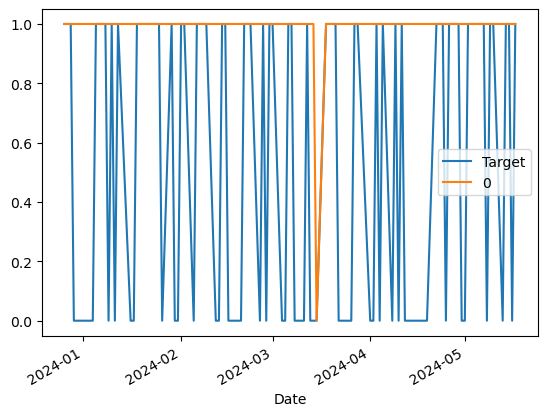

In [12]:
predictors=["Close","Volume"]
model.fit(train[predictors],train["Target"])#entrainer les predictors pour préduire le target 
#mesurer les performances du modéle

from sklearn.metrics import precision_score
preds=model.predict(test[predictors])

import pandas as pd
preds=pd.Series(preds,index=test.index)
print(precision_score(test["Target"],preds))#le resultat
combined=pd.concat([test["Target"],preds],axis=1)
combined.plot()#0 orange prediction bleu réalité

In [13]:
predictions=backtest(sp500,model,predictors)
predictions["Predictions"].value_counts()
print(precision_score(predictions["Target"],predictions["Predictions"]))

0.5451753263373432


0.5555555555555556


<Axes: xlabel='Date'>

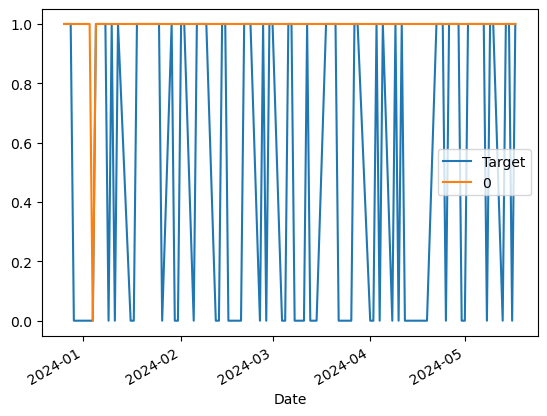

In [14]:
 predictors=["Close"]
model.fit(train[predictors],train["Target"])#entrainer les predictors pour préduire le target 
#mesurer les performances du modéle

from sklearn.metrics import precision_score
preds=model.predict(test[predictors])

import pandas as pd
preds=pd.Series(preds,index=test.index)
print(precision_score(test["Target"],preds))#le resultat
combined=pd.concat([test["Target"],preds],axis=1)
combined.plot()#0 orange prediction bleu réalité

In [15]:
predictions=backtest(sp500,model,predictors)
predictions["Predictions"].value_counts()
print(precision_score(predictions["Target"],predictions["Predictions"]))

0.5351681957186545


0.5245901639344263


<Axes: xlabel='Date'>

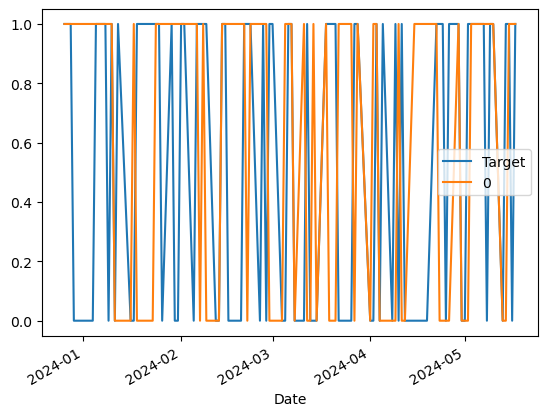

In [16]:
 predictors=["Volume"]
model.fit(train[predictors],train["Target"])#entrainer les predictors pour préduire le target 
#mesurer les performances du modéle

from sklearn.metrics import precision_score
preds=model.predict(test[predictors])

import pandas as pd
preds=pd.Series(preds,index=test.index)
print(precision_score(test["Target"],preds))#le resultat
combined=pd.concat([test["Target"],preds],axis=1)
combined.plot()#0 orange prediction bleu réalité

In [17]:
predictions=backtest(sp500,model,predictors)
predictions["Predictions"].value_counts()
print(precision_score(predictions["Target"],predictions["Predictions"]))

0.5431292517006803


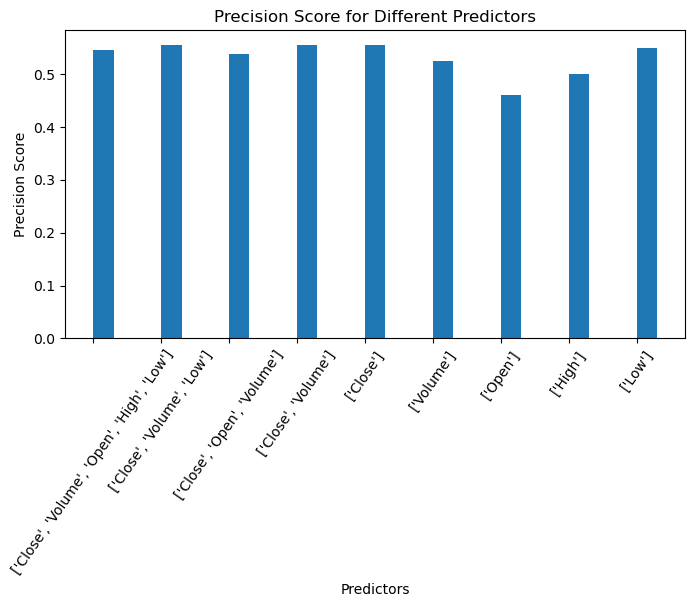

In [18]:
import matplotlib.pyplot as plt
import numpy as np

X = [["Close", "Volume", "Open", "High", "Low"], ["Close", "Volume", "Low"],["Close","Open","Volume"], ["Close", "Volume"], ["Close"], ["Volume"],["Open"],["High"],["Low"]]
Y = []

# Supposez que vous avez déjà créé et ajusté votre modèle (model) avant cette partie du code

for predictors in X:
    model.fit(train[predictors], train["Target"])  # entraîner les prédicteurs pour prédire la cible
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index)
    precision = precision_score(test["Target"], preds)
    Y.append(precision)

# Tracé des histogrammes
fig, ax = plt.subplots(figsize=(8, 4))
bar_width = 0.3  # Largeur des barres

# Utilisation de l'espace entre les indices pour positionner les barres
indices = np.arange(len(X))

ax.bar(indices, Y, bar_width, align='edge')

# Étiquetage des axes avec rotation à 90 degrés
ax.set_xticks(indices)
ax.set_xticklabels([str(predictors) for predictors in X], rotation=55)  # Rotation à 90 degrés

plt.xlabel('Predictors')
plt.ylabel('Precision Score')
plt.title('Precision Score for Different Predictors')

# Affichage du graphique
plt.show()

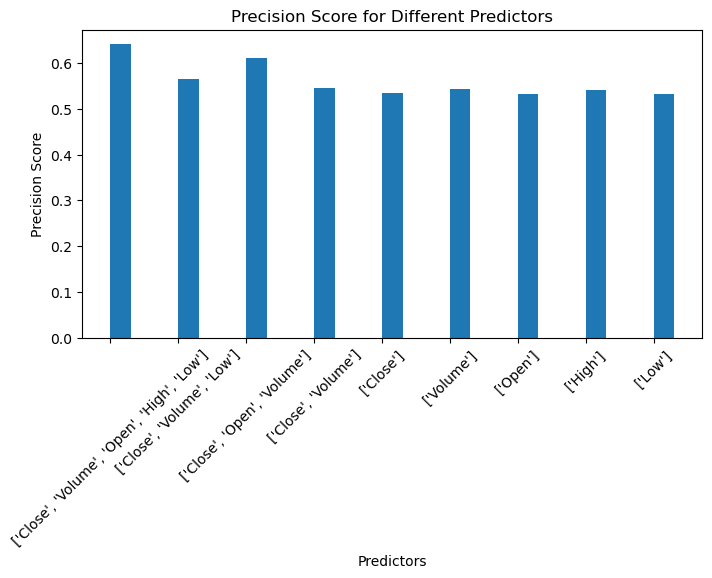

In [19]:
import matplotlib.pyplot as plt
import numpy as np

X = [["Close", "Volume", "Open", "High", "Low"], ["Close", "Volume", "Low"],["Close","Open","Volume"], ["Close", "Volume"], ["Close"], ["Volume"],["Open"],["High"],["Low"]]
Y = []

# Supposez que vous avez déjà créé et ajusté votre modèle (model) avant cette partie du code

for predictors in X:
    predictions=backtest(sp500,model,predictors)
    predictions["Predictions"].value_counts()
    Y.append(precision_score(predictions["Target"],predictions["Predictions"]))

# Tracé des histogrammes
fig, ax = plt.subplots(figsize=(8, 4))
bar_width = 0.3  # Largeur des barres

# Utilisation de l'espace entre les indices pour positionner les barres
indices = np.arange(len(X))

ax.bar(indices, Y, bar_width, align='edge')

# Étiquetage des axes avec rotation à 90 degrés
ax.set_xticks(indices)
ax.set_xticklabels([str(predictors) for predictors in X], rotation=45)  # Rotation à 90 degrés

plt.xlabel('Predictors')
plt.ylabel('Precision Score')
plt.title('Precision Score for Different Predictors')

# Affichage du graphique
plt.show()

In [20]:
window_size = 20  # Vous pouvez ajuster cela en fonction des besoins 

# Calculer le SMA en utilisant la méthode rolling de pandas
sp500["SMA"] = sp500["Close"].rolling(window=window_size).mean()
sp500.dropna(inplace=True)

In [21]:
window_size = 20

# Calculer l'EMA en utilisant la méthode ewm de pandas
sp500["EMA"] = sp500["Close"].ewm(span=window_size, adjust=False).mean()

# Supprimer les lignes contenant des NaN
sp500.dropna(inplace=True)

In [22]:
import numpy as np
Poids = [5, 4, 3, 2, 1]
Periode=5
sp500['MMP'] = sp500['Close'].rolling(window=5).apply(lambda prices: np.dot(prices, Poids) / sum(Poids), raw=True)

# Supprimer les lignes contenant des NaN
sp500.dropna(inplace=True)


In [23]:
window_size = 20
sp500['TMA'] = sp500['SMA'].rolling(window=window_size).mean()

# Supprimer les lignes contenant des NaN
sp500.dropna(inplace=True)


In [24]:
short_window = 12
long_window = 26
signal_window = 9

# Calculer les moyennes mobiles exponentielles (EMA)
sp500['Short_EMA'] = sp500['Close'].ewm(span=short_window, adjust=False).mean()
sp500['Long_EMA'] = sp500['Close'].ewm(span=long_window, adjust=False).mean()
sp500['MACD'] = sp500['Short_EMA'] - sp500['Long_EMA']
sp500['Signal_Line'] = sp500['MACD'].ewm(span=signal_window, adjust=False).mean()
# Supprimer les lignes contenant des NaN
sp500.dropna(inplace=True)

In [25]:
print(sp500)

                                  Open         High          Low        Close  \
Date                                                                            
1990-03-02 00:00:00-05:00   332.739990   335.540009   332.720001   335.540009   
1990-03-05 00:00:00-05:00   335.540009   336.380005   333.489990   333.739990   
1990-03-06 00:00:00-05:00   333.739990   337.929993   333.570007   337.929993   
1990-03-07 00:00:00-05:00   337.929993   338.839996   336.329987   336.950012   
1990-03-08 00:00:00-05:00   336.950012   340.660004   336.950012   340.269989   
...                                ...          ...          ...          ...   
2024-05-13 00:00:00-04:00  5233.080078  5237.259766  5211.160156  5221.419922   
2024-05-14 00:00:00-04:00  5221.100098  5250.370117  5217.979980  5246.680176   
2024-05-15 00:00:00-04:00  5263.259766  5311.759766  5263.259766  5308.149902   
2024-05-16 00:00:00-04:00  5310.069824  5325.490234  5296.189941  5297.100098   
2024-05-17 00:00:00-04:00  5

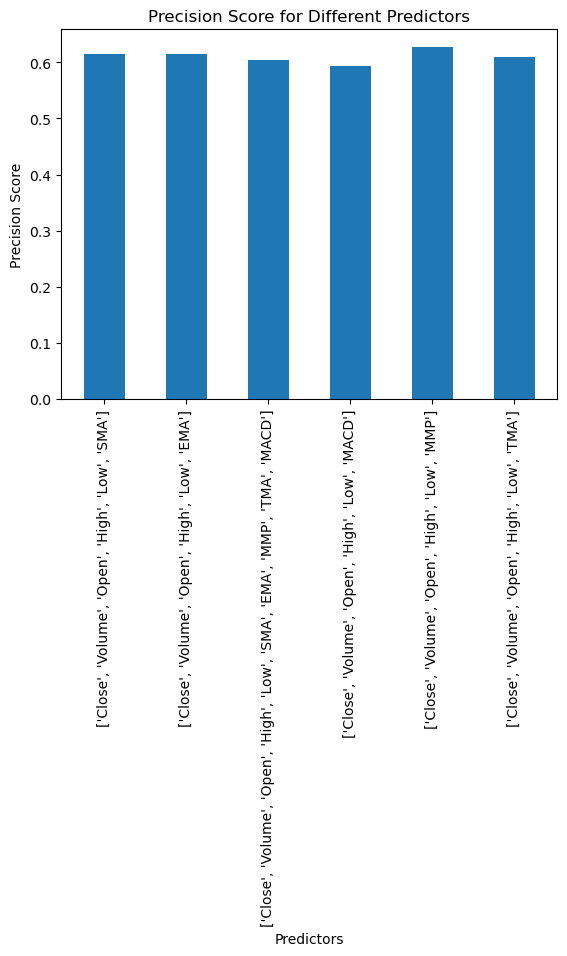

In [26]:
import matplotlib.pyplot as plt
import numpy as np

X = [["Close", "Volume", "Open", "High", "Low","SMA"], ["Close", "Volume", "Open", "High", "Low","EMA"],["Close", "Volume", "Open", "High", "Low","SMA","EMA","MMP","TMA","MACD"],["Close", "Volume", "Open", "High", "Low","MACD"],["Close", "Volume", "Open", "High", "Low","MMP"], ["Close", "Volume", "Open", "High", "Low","TMA"]] 
Y = []

# Supposez que vous avez déjà créé et ajusté votre modèle (model) avant cette partie du code

for predictors in X:
    predictions=backtest(sp500,model,predictors)
    predictions["Predictions"].value_counts()
    Y.append(precision_score(predictions["Target"],predictions["Predictions"]))

# Tracé des histogrammes
fig, ax = plt.subplots()
bar_width = 0.5  # Largeur des barres

# Utilisation de l'espace entre les indices pour positionner les barres
indices = np.arange(len(X))

ax.bar(indices, Y, bar_width, align='center')

# Étiquetage des axes avec rotation à 90 degrés
ax.set_xticks(indices)
ax.set_xticklabels([str(predictors) for predictors in X], rotation=90)  # Rotation à 90 degrés

plt.xlabel('Predictors')
plt.ylabel('Precision Score')
plt.title('Precision Score for Different Predictors')

# Affichage du graphique
plt.show()

0.547945205479452


<Axes: xlabel='Date'>

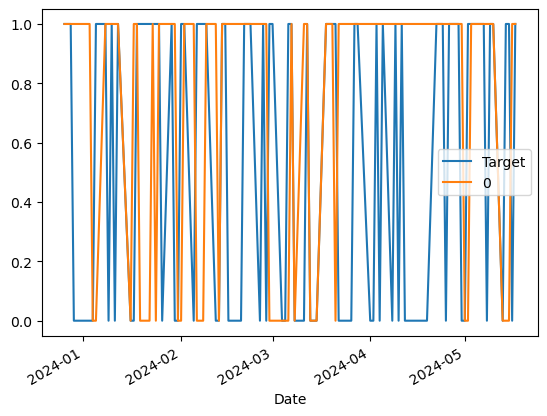

In [27]:
from sklearn.ensemble import RandomForestClassifier#peut détecter les non linearités entre les parametres
#random traine un groupe d'arbre de décision individuels avce des paramétres randoms puis faire la moyenne de ces resulats 
model=RandomForestClassifier(n_estimators=100,min_samples_split=100,random_state=1)
train=sp500.iloc[:-100]
test=sp500.iloc[-100:]#les 100 dernieres lignes
predictors=["SMA", "Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors],train["Target"])#entrainer les predictors pour préduire le target 
#mesurer les performances du modéle

from sklearn.metrics import precision_score
preds=model.predict(test[predictors])

import pandas as pd
preds=pd.Series(preds,index=test.index)
print(precision_score(test["Target"],preds))#le resultat
combined=pd.concat([test["Target"],preds],axis=1)
combined.plot()#0 orange prediction bleu réalité

In [28]:
predictions=backtest(sp500,model,predictors)
predictions["Predictions"].value_counts()
print(precision_score(predictions["Target"],predictions["Predictions"]))

0.6281978396816373


In [29]:
window_size = 20

# Calculer l'EMA en utilisant la méthode ewm de pandas
sp500['EMA'] = sp500['Close'].ewm(span=window_size, adjust=False).mean()

# Supprimer les lignes contenant des NaN
sp500.dropna(inplace=True)

In [30]:
print(sp500)

                                  Open         High          Low        Close  \
Date                                                                            
1990-03-02 00:00:00-05:00   332.739990   335.540009   332.720001   335.540009   
1990-03-05 00:00:00-05:00   335.540009   336.380005   333.489990   333.739990   
1990-03-06 00:00:00-05:00   333.739990   337.929993   333.570007   337.929993   
1990-03-07 00:00:00-05:00   337.929993   338.839996   336.329987   336.950012   
1990-03-08 00:00:00-05:00   336.950012   340.660004   336.950012   340.269989   
...                                ...          ...          ...          ...   
2024-05-13 00:00:00-04:00  5233.080078  5237.259766  5211.160156  5221.419922   
2024-05-14 00:00:00-04:00  5221.100098  5250.370117  5217.979980  5246.680176   
2024-05-15 00:00:00-04:00  5263.259766  5311.759766  5263.259766  5308.149902   
2024-05-16 00:00:00-04:00  5310.069824  5325.490234  5296.189941  5297.100098   
2024-05-17 00:00:00-04:00  5

0.5454545454545454


<Axes: xlabel='Date'>

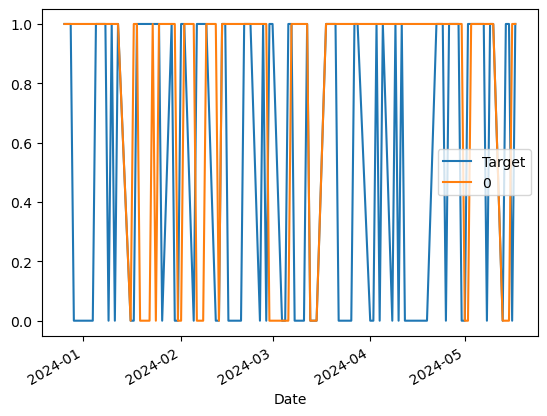

In [31]:
from sklearn.ensemble import RandomForestClassifier#peut détecter les non linearités entre les parametres
#random traine un groupe d'arbre de décision individuels avce des paramétres randoms puis faire la moyenne de ces resulats 
model=RandomForestClassifier(n_estimators=100,min_samples_split=100,random_state=1)
train=sp500.iloc[:-100]
test=sp500.iloc[-100:]#les 100 dernieres lignes
predictors=["EMA", "Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors],train["Target"])#entrainer les predictors pour préduire le target 
#mesurer les performances du modéle

from sklearn.metrics import precision_score
preds=model.predict(test[predictors])

import pandas as pd
preds=pd.Series(preds,index=test.index)
print(precision_score(test["Target"],preds))#le resultat
combined=pd.concat([test["Target"],preds],axis=1)
combined.plot()#0 orange prediction bleu réalité

In [32]:
predictions=backtest(sp500,model,predictors)
predictions["Predictions"].value_counts()
print(precision_score(predictions["Target"],predictions["Predictions"]))

0.6222222222222222


0.547945205479452


<Axes: xlabel='Date'>

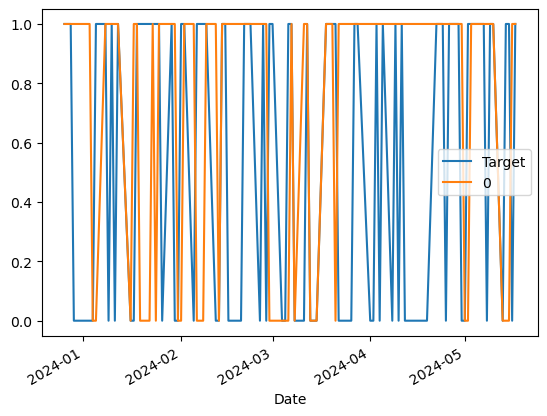

In [33]:
from sklearn.ensemble import RandomForestClassifier#peut détecter les non linearités entre les parametres
#random traine un groupe d'arbre de décision individuels avce des paramétres randoms puis faire la moyenne de ces resulats 
model=RandomForestClassifier(n_estimators=100,min_samples_split=100,random_state=1)
train=sp500.iloc[:-100]
test=sp500.iloc[-100:]#les 100 dernieres lignes
predictors=["SMA","EMA", "Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors],train["Target"])#entrainer les predictors pour préduire le target 
#mesurer les performances du modéle

from sklearn.metrics import precision_score
preds=model.predict(test[predictors])

import pandas as pd
preds=pd.Series(preds,index=test.index)
print(precision_score(test["Target"],preds))#le resultat
combined=pd.concat([test["Target"],preds],axis=1)
combined.plot()#0 orange prediction bleu réalité

In [34]:
predictions=backtest(sp500,model,predictors)
predictions["Predictions"].value_counts()
print(precision_score(predictions["Target"],predictions["Predictions"]))

0.6161473087818697


In [35]:
weights = [5, 4, 3, 2, 1]
import numpy as np
# Calculer la moyenne pondérée en utilisant la méthode rolling de pandas
sp500['MMP'] = sp500['Close'].rolling(window=5).apply(lambda prices: np.dot(prices, weights) / sum(weights), raw=True)

# Supprimer les lignes contenant des NaN
sp500.dropna(inplace=True)
print(sp500)

                                  Open         High          Low        Close  \
Date                                                                            
1990-03-08 00:00:00-05:00   336.950012   340.660004   336.950012   340.269989   
1990-03-09 00:00:00-05:00   340.119995   340.269989   336.839996   337.929993   
1990-03-12 00:00:00-05:00   337.929993   339.079987   336.140015   338.670013   
1990-03-13 00:00:00-05:00   338.670013   338.670013   335.359985   336.000000   
1990-03-14 00:00:00-05:00   336.000000   337.630005   334.929993   336.869995   
...                                ...          ...          ...          ...   
2024-05-13 00:00:00-04:00  5233.080078  5237.259766  5211.160156  5221.419922   
2024-05-14 00:00:00-04:00  5221.100098  5250.370117  5217.979980  5246.680176   
2024-05-15 00:00:00-04:00  5263.259766  5311.759766  5263.259766  5308.149902   
2024-05-16 00:00:00-04:00  5310.069824  5325.490234  5296.189941  5297.100098   
2024-05-17 00:00:00-04:00  5

In [36]:
window_size = 10

# Calculer la moyenne mobile simple (SMA) sur la fenêtre définie
sp500['SMA'] = sp500['Close'].rolling(window=window_size).mean()

# Calculer la moyenne mobile triangulaire (TMA)
sp500['TMA'] = sp500['SMA'].rolling(window=window_size).mean()

# Supprimer les lignes contenant des NaN
sp500.dropna(inplace=True)
print(sp500)

                                  Open         High          Low        Close  \
Date                                                                            
1990-04-03 00:00:00-04:00   338.700012   343.760010   338.700012   343.640015   
1990-04-04 00:00:00-04:00   343.640015   344.119995   340.399994   341.089996   
1990-04-05 00:00:00-04:00   341.089996   342.850006   340.630005   340.730011   
1990-04-06 00:00:00-04:00   340.730011   341.730011   338.940002   340.079987   
1990-04-09 00:00:00-04:00   340.079987   341.829987   339.880005   341.369995   
...                                ...          ...          ...          ...   
2024-05-13 00:00:00-04:00  5233.080078  5237.259766  5211.160156  5221.419922   
2024-05-14 00:00:00-04:00  5221.100098  5250.370117  5217.979980  5246.680176   
2024-05-15 00:00:00-04:00  5263.259766  5311.759766  5263.259766  5308.149902   
2024-05-16 00:00:00-04:00  5310.069824  5325.490234  5296.189941  5297.100098   
2024-05-17 00:00:00-04:00  5